https://github.com/modflowpy/flopy/blob/develop/examples/Tutorials/Tutorial02/tutorial02.py
And example problems that are described in the 1999 MT3DMS report...also see flopy3_MT3DMS_examples.py.

In [64]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
%matplotlib inline

In [65]:
#Set working directory and names
ws = 'D:/Chelsea/Projects/DelawareStream/FloPy/Tutorial02wMT3DMS'
wspath = 'D:/Chelsea/Projects/DelawareStream/FloPy/Tutorial02wMT3DMS/'
if not os.path.exists(ws): #make sure workspace directory exists
    os.makedirs(ws)
name = 'Tutorial02wMT3DMS'
exe_name_mf = os.path.abspath('D:/Chelsea/Projects/DelawareStream/Script/Executables/mf2005')
exe_name_mt = os.path.abspath('D:/Chelsea/Projects/DelawareStream/Script/Executables/mt3dms')

In [66]:
# Model domain and grid definition
Lx = 1000. #total width across rows of entire model
Ly = 1000. #total width across columns
ztop = 10. #top elevation of layer 1
zbot = -50. #bottom elevation
nlay = 1 #number of layers
nrow = 10 #number of rows
ncol = 10 #number of columns
delr = Lx / ncol #the cell width along rows
delc = Ly / nrow #the cell width along columns
delv = (ztop - zbot) / nlay #elevation change from top to bottom of model
botm = np.linspace(ztop, zbot, nlay + 1) # bottom elevation of each layer including top elevation 
hk = 1. #hydraulic conductivity along rows
vka = 1. #vertical hydraulic conductivity
sy = 0.1 #specific yield
ss = 1.e-4 #specific storage
laytyp = 1 #layer type, 0 - confined, >0 - convertible, <0 - convertialbe unless THICKSTRT

In [67]:
# Variables for the BAS package, which is used to specify (1) the location of active, inactive, and specified head cells, 
# (2) the head stored in inactive cells, and (3) the initial heads in all cells.
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #boundary variable... one value for every cell... if >0 cell is active, if =0 cell is inactive, if <0 cell has constant head. 
strt = 10. * np.ones((nlay, nrow, ncol), dtype=np.float32) #initial starting head... one value for every cell

In [68]:
# Time step parameters
nper = 5 #number of stress periods
perlen_num = 100# [1, 100, 100] 
perlen = np.ones(nper, dtype=np.int) * perlen_num #length of stress period
perlen[0] = 1 #number of time steps in each stress period
nstp = perlen
steady = [False] * nper
steady[0] = True #transient or steady state

endtime = np.cumsum(perlen)

In [69]:
# FloPy objects
mf = flopy.modflow.Modflow(modelname=name, model_ws=ws, exe_name=exe_name_mf)
# Creates Discretization File, which gives (1) the number of rows, columns and layers, (2) the cell sizes, 
# (3) the presence of Quasi-3D confining beds, and (4) the time discretization.
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc, 
                               top=ztop, botm=botm[1:], #ony takes the bottom... excludes the top elevation
                               nper=nper, perlen=perlen, nstp=nstp, steady=steady)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
# The Layer-Property Flow package is used to specify properties controlling flow between cells.
# Ipakcb - A flag that is used to determine if cell-by-cell budget data should be saved. If ipakcb is non-zero cell-by-cell 
# budget data will be saved. (default is 53)
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, 
                               ipakcb=53) 
# The Preconditioned Conjugate-Gradient package is used to solve the finite difference 
# equations in each step of a MODFLOW stress period.
pcg = flopy.modflow.ModflowPcg(mf) 

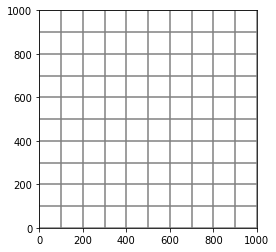

In [70]:
mm = flopy.plot.PlotMapView(model=mf)
plota = mm.plot_grid()

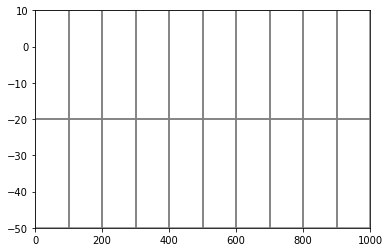

In [71]:
mm2 = flopy.plot.PlotCrossSection(model=mf, line={'row': 2})
plotb = mm2.plot_grid()

In [72]:
# Make list for stress period 1
stageleft = 10.
stageright = 10.
bound_sp1 = []
for il in range(nlay):
    condleft = hk * (stageleft - zbot) * delc #hydraulic conductivity * area of left face 
    condright = hk * (stageright - zbot) * delc
    for ir in range(nrow):
        bound_sp1.append([il, ir, 0, stageleft, condleft]) #layer, row, column, head on boundary, and conductance
        bound_sp1.append([il, ir, ncol - 1, stageright, condright])
print('Adding ', len(bound_sp1), 'GHBs for stress period 1.') #which is the left and right boundary conditions

Adding  40 GHBs for stress period 1.


In [73]:
# Make list for stress period 2
# In the stress period 2, the head drops to 0 and becomes less conductive at the right boundary.
stageleft = 10.
stageright = 0.
condleft = hk * (stageleft - zbot) * delc #hydraulic conductivity * area of left face 
condright = hk * (stageright - zbot) * delc
bound_sp2 = []
for il in range(nlay):
    for ir in range(nrow):
        bound_sp2.append([il, ir, 0, stageleft, condleft])
        bound_sp2.append([il, ir, ncol - 1, stageright, condright])
print('Adding ', len(bound_sp2), 'GHBs for stress period 2.') 

Adding  40 GHBs for stress period 2.


In [74]:
# We do not need to add a dictionary entry for stress period 3.
# Flopy will automatically take the list from stress period 2 and apply it
# to the end of the simulation
stress_period_data = {0: bound_sp1, 1: bound_sp2}

In [75]:
# Create the flopy ghb object
# The General-Head Boundary package is used to simulate head-dependent flux boundaries.  
# In the General-Head Boundary package the flux is always proportional to the difference in head.
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=stress_period_data)

In [76]:
# Create the well package
# Remember to use zero-based layer, row, column indices!
# The Well package is used to simulate a specified flux to individual cells and specified in units of length3/time.
# Here the well is only pumped during the third stress period. The well is located in the middle of model.
pumping_rate = 1000. #length3/time
wel_sp1 = [[0, nrow/2 - 1, ncol/2 - 1, 0.]] #layer, row, col, volumetric recharge rate (+ is recharge, and - is pumping)
wel_sp2 = [[0, nrow/2 - 1, ncol/2 - 1, 500.]]
wel_sp3 = [[0, nrow/2 - 1, ncol/2 - 1, pumping_rate]]
wel_sp4 = [[0, nrow/2 - 1, ncol/2 - 1, 700.]]
wel_sp5 = [[0, nrow/2 - 1, ncol/2 - 1, -500.]]
stress_period_data1 = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3, 3: wel_sp4, 4: wel_sp5}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data1)

In [77]:
# Output control
# The Output Control Option is used to specify which head, drawdown, or budget data should be printed or saved.
stress_period_data = {}
for kper in range(nper): #for each stress period
    for kstp in range(nstp[kper]): #for each time period
        stress_period_data[(kper, kstp)] = ['save head',
                                            'save drawdown',
                                            'save budget',
                                            'print head',
                                            'print budget']
oc = flopy.modflow.ModflowOc(mf, stress_period_data=stress_period_data, compact=True)

In [78]:
# The Link-MT3DMS package is used to record flow information for use by MT3DMS
lmt = flopy.modflow.ModflowLmt(mf)

In [79]:
# Write the model input files
mf.write_input()

In [80]:
# Run the model
success, mfoutput = mf.run_model(silent=True, pause=False)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

In [81]:
# Add MT3DMS components
mt = flopy.mt3d.Mt3dms(modelname=name, model_ws=ws, exe_name=exe_name_mt, modflowmodel=mf)

# Inputs for boundary conditions
v = 1. / 3. #groundwater seepage velocity, L/T
prsity = 0.3 #porosity
q = v * prsity #flux
al = 10. #longitudinal dispersivity, L
trpt = .3 #ratio of transverse to longitudinal dispersivity
q0 = 1. #volumetric injection rate, L3/T
c0 = 1000. #concentration of injected water, ppm
sconc = 0 #starting concentration

In [82]:
# Basic Transport Package
# The icbund array specifies the boundary condition type for solute species (shared by all species). 
# If icbund = 0, the cell is an inactive concentration cell; If icbund < 0, constant-concentration cell; If icbund > 0, 
# the cell is an active concentration cell where the concentration value will be calculated.
obs = [[1 - 1, 5 - 1, 5 - 1],[1 - 1, 8 - 1, 5 - 1],[1 - 1, 3 - 1, 5 - 1]] #create observation points
btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=sconc, obs=obs)

In [83]:
# Advection
mixelm = 1 # integer flag for the advection solution option
dceps = 1.e-5 #small relative cell concentration gradient below which advection transport is considered
nplane = 1 #flag indicating whether random or fixed pattern is selected for initial placement (0 = random, 1 = 2D, 2 = 3D)
npl = 0 #num of initial particles per cell to placed at cells where <= decps
nph = 16 #num of initial particles per cell to placed at cells where >= decps
npmin = 2 #min num of particles allowed per cell
npmax = 32 #max num of particles allowed per cell
dchmoc=1.e-3 #critical Relative Concentration Gradient for controlling use of either MOC or MMOC in the HMOC solution scheme.
nlsink = nplane #flag indicating whether the random or fixed pattern is selected for initial placement of particles to approximate sink cells
npsink = nph #number of particles used to approximate sink cells in the MMOC scheme. 

adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                             npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                             nlsink=nlsink, npsink=npsink, percel=0.5)

# Dispersion
dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)

# Source and Sink Mixing Package
spd = {0:[0, 4, 4, sconc, 2], 1:[0, 4, 4, c0, 2], 2:[0, 4, 4, c0, 2],
      3:[0, 4, 4, c0, 2], 4:[0, 4, 4, c0, 2]} #stress period, where last value is the type of cell
ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)

# Generalized Conjugate Gradient Package Class
gcg = flopy.mt3d.Mt3dGcg(mt)

In [84]:
mt.write_input()

fname = os.path.join(wspath+'MT3D001.UCN')
#if os.path.isfile(fname):
#    os.remove(fname)
mt.run_model(silent=True, pause=False, report=True, normal_msg = 'normal termination')

(False,
 [' MT3DMS - Modular 3-D Multi-Species Transport Model [Version 5.30]',
  ' Developed at University of Alabama for U.S. Department of Defense',
  '',
  ' Using NAME File: Tutorial02wMT3DMS.nam                             ',
  '',
  ' STRESS PERIOD NO.    1',
  '',
  ' TIME STEP NO.    1',
  ' FROM TIME =   0.0000     TO    1.0000    ',
  '',
  ' Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    ',
  ' Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1',
  '',
  ' STRESS PERIOD NO.    2',
  '',
  ' TIME STEP NO.    1',
  ' FROM TIME =   1.0000     TO    2.0000    ',
  '',
  ' Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2.0000    ',
  ' Outer Iter.  1  Inner Iter.  1:  Max. DC =   5.520      [K,I,J]    1    5    5',
  ' Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3131E-08  [K,I,J]    1    4    6',
  '',
  ' TIME STEP NO.    2',
  ' FROM TIME =   2.0000     TO    3.0000    ',
  '',
  ' Transport Step

In [85]:
# Create the headfile and budget file objects
headobj = bf.HeadFile(wspath+name+'.hds')
times = headobj.get_times()
cbb = bf.CellBudgetFile(wspath+name+'.cbc')

fname = os.path.join(ws, 'MT3D001.UCN')
ucnobj = flopy.utils.UcnFile(fname)
timesconc = ucnobj.get_times()
conc = ucnobj.get_alldata()

fname = os.path.join(ws, 'MT3D001.OBS')
if os.path.isfile(fname):
    cvt = mt.load_obs(fname)
else:
    cvt = None

fname = os.path.join(ws, 'MT3D001.MAS')
mvt = mt.load_mas(fname)

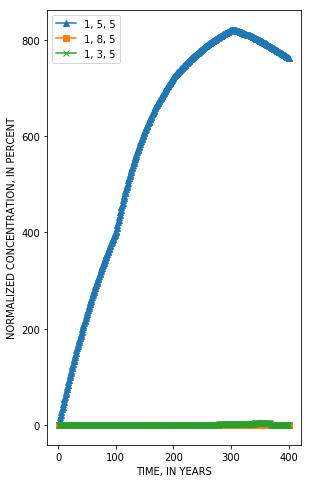

In [86]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 2, 1)
#mf, mt, conc, cvt, mvt   = p06('p06', 1, 56.25)
x = cvt['time']
y = cvt['(1, 5, 5)']
ax.plot(x, y, label='1, 5, 5', marker='^')

x = cvt['time']
y = cvt['(1, 8, 5)']
ax.plot(x, y, label='1, 8, 5', marker='s')

x = cvt['time']
y = cvt['(1, 3, 5)']
ax.plot(x, y, label='1, 3, 5', marker='x')

#plt.xlim(0, 10)
#plt.ylim(0, 100.0)
plt.xlabel('TIME, IN YEARS')
plt.ylabel('NORMALIZED CONCENTRATION, IN PERCENT')
plt.legend()

In [87]:
# Setup contour parameters
levels = np.linspace(0, 10, 11)
extent = (delr/2., Lx - delr/2., delc/2., Ly - delc/2.)
print('Levels: ', levels)
print('Extent: ', extent)

Levels:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Extent:  (50.0, 950.0, 50.0, 950.0)


In [88]:
# Well point
wpt = ((float(ncol/2)-0.5)*delr, (float(nrow/2-1)+0.5)*delc)
print(wpt)
obspt = ((float(8)-0.5)*delr, (float(8-1)+0.5)*delc)
print(obspt)

(450.0, 450.0)
(750.0, 750.0)


In [89]:
# Locations for observation points
obs2 = np.add(obs, [1,1,1])
obs3 = [1, delr, delc]
obs4 = np.multiply(obs2, obs3)
obs5 = np.subtract(obs4, [1., delr/2, delc/2])
obs6 = [i[1:] for i in obs5]
obsx =  [i[0] for i in obs6]
obsy =  [i[1] for i in obs6]

*****Processing time:  1
Head statistics
  min:  10.0
  max:  10.0
  std:  0.0
*****Processing time:  101
Head statistics
  min:  0.011631503
  max:  12.673315
  std:  3.4183943
*****Processing time:  201
Head statistics
  min:  0.008937113
  max:  16.139854
  std:  3.6475453
*****Processing time:  301
Head statistics
  min:  0.008092476
  max:  13.327488
  std:  3.4644685
*****Processing time:  401
Head statistics
  min:  0.006731966
  max:  9.996736
  std:  3.1648927


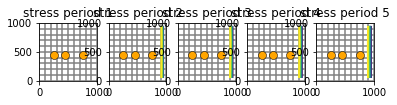

In [94]:
# Make the plots
#mytimes = [1.0, 101.0, 201.0]
#mytimes = [1.0, 101.0, 201.0, 301.0, 401.0]
mytimes = endtime
for iplot, time in enumerate(mytimes):
    print('*****Processing time: ', time)
    head = headobj.get_data(totim=time)
    #Print statistics
    print('Head statistics')
    print('  min: ', head.min())
    print('  max: ', head.max())
    print('  std: ', head.std())

    # Extract flow right face and flow front face
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=time)[0]
    fff = cbb.get_data(text='FLOW FRONT FACE', totim=time)[0]

    #Create the plot
    plt.subplot(1, len(mytimes), iplot + 1, aspect='equal')
    #plt.subplot(1, 1, 1, aspect='equal')
    plt.title('stress period ' + str(iplot + 1))


    modelmap = flopy.plot.PlotMapView(model=mf, layer=0)
    qm = modelmap.plot_ibound()
    lc = modelmap.plot_grid()
    #qm = modelmap.plot_bc('GHB')#, alpha=0.5)
    cs = modelmap.contour_array(head, levels=levels)
    #plt.clabel(cs, inline=1, fontsize=10, fmt='%1.1f')#, zorder=11
   # quiver = modelmap.plot_discharge(frf, fff, head=head)
    
    #mfc = 'None'
    #if (iplot+1) == len(mytimes):
    #    mfc='black'
    #plt.plot(wpt[0], wpt[1], lw=0, marker='o', markersize=8, 
    #         markeredgewidth=0.5,
    #         markeredgecolor='black', markerfacecolor=mfc, zorder=9)
    #plt.plot(obspt[0], obspt[1], lw=0, marker='o', markersize=8, 
    #         markeredgewidth=0.5,
    #         markeredgecolor='green', markerfacecolor='green', zorder=9)
    plt.plot(obsx, obsy, lw=0, marker='o', markersize=8, 
             markeredgewidth=0.5,
             markeredgecolor='black', markerfacecolor='orange', zorder=9)
    #plt.text(wpt[0]+25, wpt[1]-25, 'well', size=12, zorder=12)
    plt.savefig(wspath+'/Figures/'+'tutorial2-{}.png'.format(iplot))

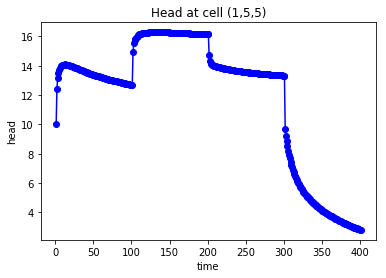

In [91]:
# Plot the head versus time
# This is the well spot, notice how pumping started ony in the last stress period
idx = (0, int(nrow/2) - 1, int(ncol/2) - 1)
ts = headobj.get_ts(idx)
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
plt.title(ttl)
plt.xlabel('time')
plt.ylabel('head')
plt.plot(ts[:, 0], ts[:, 1], 'bo-')
plt.savefig(wspath+'/Figures/'+'tutorial2-ts.png')

In [92]:
# Setup contour parameters
levels = np.linspace(0, 1, 21)
extent = (delr/2., Lx - delr/2., delc/2., Ly - delc/2.)
print('Levels: ', levels)
print('Extent: ', extent)

Levels:  [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
Extent:  (50.0, 950.0, 50.0, 950.0)


*****Processing time:  1
Concentration statistics
  min:  0.0
  max:  0.0
  std:  0.0
*****Processing time:  101
Concentration statistics
  min:  -2.6218315e-05
  max:  403.99866
  std:  28.50896
*****Processing time:  201
Concentration statistics
  min:  -0.0076021533
  max:  724.22766
  std:  58.165596
*****Processing time:  301
Concentration statistics
  min:  -0.044600327
  max:  821.2092
  std:  69.46526
*****Processing time:  401
Concentration statistics
  min:  -0.000770192
  max:  762.5058
  std:  61.999954


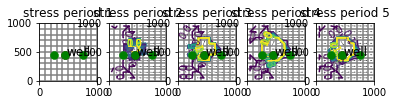

In [96]:
# Make the plots
mytimes = [1.0, 101.0, 201.0]
mytimes = [201.0]
mytimes = endtime
#mytimes = [1.0, 101.0, 201.0, 301.0, 401.0]
for iplot, time in enumerate(mytimes):
    print('*****Processing time: ', time)
    concdata = ucnobj.get_data(totim=time)
    
    #headobj.get_data(totim=time)
    #Print statistics
    print('Concentration statistics')
    print('  min: ', concdata.min())
    print('  max: ', concdata.max())
    print('  std: ', concdata.std())

    # Extract flow right face and flow front face
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=time)[0]
    fff = cbb.get_data(text='FLOW FRONT FACE', totim=time)[0]

    #Create the plot
    plt.subplot(1, len(mytimes), iplot + 1, aspect='equal')
    #plt.subplot(1, 1, 1, aspect='equal')
    plt.title('stress period ' + str(iplot + 1))


    modelmap = flopy.plot.PlotMapView(model=mt, layer=1)
    qm = modelmap.plot_ibound()
    lc = modelmap.plot_grid()
    #qm = modelmap.plot_bc('GHB')#, alpha=0.5)
    cs = modelmap.contour_array(concdata, levels=levels)
    plt.clabel(cs, inline=1, fontsize=10, fmt='%1.1f')#, zorder=11
    quiver = modelmap.plot_discharge(frf, fff, head=head)
    
    if (iplot+1) == len(mytimes):
        mfc='black'
    plt.plot(wpt[0], wpt[1], lw=0, marker='o', markersize=8, 
             markeredgewidth=0.5,
             markeredgecolor='black', markerfacecolor='orange', zorder=9)
    plt.plot(obsx, obsy, lw=0, marker='o', markersize=8, 
             markeredgewidth=0.5,
             markeredgecolor='green', markerfacecolor='green', zorder=9)
    plt.text(wpt[0]+25, wpt[1]-25, 'well', size=12, zorder=12)
    plt.savefig(wspath+'/Figures/'+'tutorial2conc-{}.png'.format(iplot))